# Toy Model: Analysis

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import pandas as pd

# my preferred settings
mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 14)
mpl.rc('axes',labelsize = 16, linewidth=1.25)
mpl.rc('xtick',labelsize = 16)
mpl.rc('ytick',labelsize = 16)
# enable math fonts
mpl.rc('mathtext', default = 'regular')
plt.rcParams['savefig.dpi'] = 400 

from sbin.sbin import suppression_factor, suppression_simulation, suppression_factor_50
from sbin.complexity import gap_complexity

import sbin.parameters as param
param.radius_valley = 0.

In [2]:
do_multiplicity = True

### Read in data saved from Filtering

In [3]:
with open("filtered_data.pkl", "rb") as f:
     data = pickle.load(f)
        
        
close = data["close"]
good = data["good"]
db_filtered = data["db_filtered"]
kois_filtered = data["kois_filtered"]
kois_good = data["kois_good"]
cks_filtered = data["cks_filtered"]
cks_good = data["cks_good"]

if not do_multiplicity:
    print("Filtering on prad err")
    kois_filtered = data["kois_filtered"][kois_good]
    cks_filtered = data["cks_filtered"][cks_good]


In [4]:
# separation values (as lists) for each star in binary sample
# for use in the simulation
tmp = db_filtered[good & close].groupby('KOI')['SepAU'].agg('unique')
binary_separations = np.concatenate(tmp.to_numpy())

# Toy Model

### Suppress the KOIs

In [21]:
# define bins for recording plotting
nbins=20
lin_histrange=[0.5,4.5]
lin_bin_edges = np.linspace(lin_histrange[0], lin_histrange[1], nbins + 1)
log_histrange=[np.log10(0.7),np.log10(6)]
log_bin_edges = np.logspace(log_histrange[0], log_histrange[1], nbins + 1)

# run trials and save the results
ntrials = 10
koi_sim_linear = np.ones((ntrials,nbins))
koi_sim_log = np.ones((ntrials,nbins))
koi_sim_npl = np.ones((ntrials,5))
frac_SE_arr = np.ones(ntrials)
mtps_arr = np.ones(ntrials)
for i in range(ntrials):
    prad_sim_tmp, sim_counts, frac_SE_arr[i], mtps_arr[i] = suppression_simulation(
        kois_filtered, binary_separations, join_on='KOI', prad_col='koi_prad', 
        sup_function=suppression_factor_50, sup_type = 'planets')
    nplanets = len(prad_sim_tmp)
    ww = 1./np.full(nplanets, nplanets, dtype=float)
    
    # histogram of planet radii (linear)
    hist, _ = np.histogram(prad_sim_tmp, 
            range=lin_histrange, bins=lin_bin_edges, weights=ww)
    koi_sim_linear[i] = hist
    
    # histogram of planet radii (log)
    hist, _ = np.histogram(prad_sim_tmp, 
            range=log_histrange, bins=log_bin_edges, weights=ww)
    koi_sim_log[i] = hist
    
    # histogram of n_planets
    nstars = len(sim_counts)
    ww = 1./np.full(nstars, nstars, dtype=float)
    hist, _ = np.histogram(sim_counts['n_planets'], weights=ww, 
                           bins=[0.5,1.5,2.5,3.5,4.5,5.5])
    koi_sim_npl[i] = hist

    

low, koi_prad_linear, high = np.percentile(koi_sim_linear, q=(2.25,50,98.75), axis=0)
e_koi_prad_linear = (high-low)/2

low, koi_prad_log, high = np.percentile(koi_sim_log, q=(2.25,50,98.75), axis=0)
e_koi_prad_log = (high-low)/2

koi_SE_frac = np.percentile(frac_SE_arr, q=(2.25,13.6,50,86.4, 98.75))
print(koi_SE_frac)

if do_multiplicity:
    koi_MTPS_frac = np.percentile(mtps_arr, q=(2.25,13.6, 50,86.4,98.75))
    print(koi_MTPS_frac)

653.0 1359.0 155.0 1004.0
694.0 1450.0 169.0 1067.0
700.0 1437.0 177.0 1038.0
671.0 1422.0 196.0 989.0
713.0 1446.0 179.0 1059.0
687.0 1429.0 181.0 1026.0
678.0 1413.0 173.0 1033.0
694.0 1410.0 169.0 1030.0
675.0 1395.0 166.0 1019.0
676.0 1432.0 175.0 1045.0
[0.47191038 0.47353506 0.48062807 0.49106231 0.49298472]
[0.13434255 0.13748246 0.14344602 0.14899995 0.16366359]


###  Suppress CKS

In [17]:
cks_sim_linear = np.ones((ntrials,nbins))
cks_sim_log = np.ones((ntrials,nbins))
cks_sim_npl = np.ones((ntrials,5))
for i in range(ntrials):
    prad_sim_tmp, sim_counts, frac_SE_arr[i], mtps_arr[i] = suppression_simulation(
        cks_filtered, binary_separations, join_on='KOI', prad_col='Rp', 
        sup_function=suppression_factor_50, sup_type='systems')

    nplanets = len(prad_sim_tmp)
    ww = 1./np.full(nplanets, nplanets, dtype=float)
    
    # histogram of planet radii (linear)
    hist, _ = np.histogram(prad_sim_tmp, 
            range=lin_histrange, bins=lin_bin_edges, weights=ww)
    cks_sim_linear[i] = hist
    
    # histogram of planet radii (log)
    hist, _ = np.histogram(prad_sim_tmp, 
            range=log_histrange, bins=log_bin_edges, weights=ww)
    cks_sim_log[i] = hist
    

    # histogram of n_planets
    nstars = len(sim_counts)
    ww = 1./np.full(nstars, nstars, dtype=float)
    hist, _ = np.histogram(sim_counts['n_planets'], weights=ww, 
                           bins=[0.5,1.5,2.5,3.5,4.5,5.5])
    cks_sim_npl[i] = hist
    
    
low, cks_prad_linear, high = np.percentile(cks_sim_linear, q=(2.25,50,98.75), axis=0)
e_cks_prad_linear = (high-low)/2

low, cks_prad_log, high = np.percentile(cks_sim_log, q=(2.25,50,98.75), axis=0)
e_cks_prad_log = (high-low)/2

cks_SE_frac = np.percentile(frac_SE_arr, q=(2.25,13.6, 50,86.4,98.75))

print(cks_SE_frac)

if do_multiplicity:
    cks_MTPS_frac = np.percentile(mtps_arr, q=(2.25,13.6, 50,86.4,98.75))
    print(cks_MTPS_frac)

235.0 458.0 102.0 210.0
224.0 445.0 94.0 219.0
241.0 439.0 92.0 217.0
230.0 451.0 98.0 215.0
198.0 405.0 85.0 201.0
236.0 448.0 94.0 222.0
222.0 422.0 91.0 210.0
248.0 467.0 106.0 218.0
244.0 487.0 106.0 228.0
227.0 438.0 98.0 204.0
[0.49134679 0.50155177 0.51568264 0.53009422 0.5469583 ]
[0.29725657 0.297528   0.30771231 0.32638105 0.32713378]


# Plot the results

### Radius

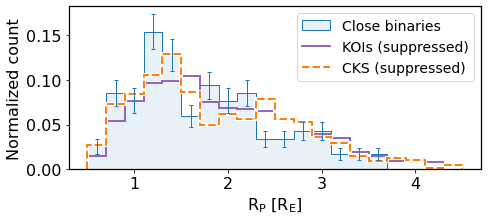

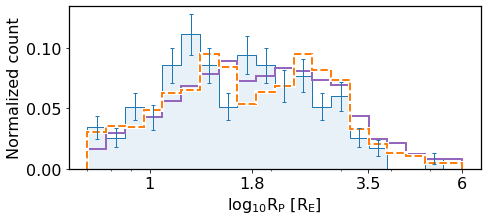

In [18]:
from scipy.stats import gaussian_kde

for option in ['linear','log']:
    
    if option=='linear':
        my_bins=lin_bin_edges
        my_prad_k=koi_prad_linear
        e_my_prad_k=e_koi_prad_linear
        my_prad_c=cks_prad_linear
        e_my_prad_c=e_cks_prad_linear
    else:
        my_bins=log_bin_edges
        my_prad_k=koi_prad_log
        e_my_prad_k=e_koi_prad_log
        my_prad_c=cks_prad_log
        e_my_prad_c=e_cks_prad_log
       
    fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

    # planets with good radii in binary systems with rho<100 au and planet period < 100 days
    nplanets = len(db_filtered[good & close])
    ww = 1./np.full(nplanets, nplanets, dtype=float)
    y, _, _ = plt.hist(db_filtered['Rppri'][good & close], 
                 bins=my_bins, weights=ww,
             histtype='stepfilled', edgecolor='#1f77b4', facecolor='#e8f1f7',
            label='Close binaries')

    plt.hist(db_filtered['Rppri'][good & close], 
                 bins=my_bins, weights=ww,
                 histtype='stepfilled',  edgecolor='#1f77b4', facecolor='#e8f1f7')
    x = my_bins[:-1]+np.diff(my_bins)/2.
    plt.errorbar(x, y, np.sqrt(y)/len(y), ls='None', lw=1, capsize=2, c='C0')


    x = my_bins[:-1]+np.diff(my_bins)/2.
    plt.stairs(my_prad_k, my_bins, color='C4', linewidth=2, label='KOIs (suppressed)')
    #plt.errorbar(x, my_prad_k, e_my_prad_k, c='C4', ls='None', lw=2, capsize=2)
    plt.stairs(my_prad_c, my_bins, color='w', linewidth=4)
    plt.stairs(my_prad_c, my_bins, color='C1', linestyle='--',linewidth=2, label='CKS (suppressed)')
    #plt.errorbar(x, my_prad_c, e_my_prad_c, c='C1', ls='None', lw=2, capsize=2)

    #y = np.concatenate(([0], cks_prad_sim, [0]))
    #plt.errorbar(bin_center-0.02, koi_prad_sim, e_koi_prad_sim, ls='None', lw=2, capsize=3, c='C4')
    #plt.errorbar(bin_center+0.025, cks_prad_sim, e_cks_prad_sim, ls='None', lw=2, capsize=2, c='C1')

    #plt.text(0.98, 0.95, 'KOIs & CKS: $R_P>1.7 R_E$ suppressed',
    #     horizontalalignment='right',
    #     verticalalignment='top',
    #     fontsize=12,
    #     transform = axes.transAxes)


    if option=='linear':
        plt.legend()
        plt.xlabel('$R_P$ [$R_E$]')        
    else:
        plt.xlabel('$log_{10} R_P$ [$R_E$]')  
        plt.xscale('log')
        
        custom_log_ticks = [1, 1.8, 3.5, 6]
        plt.gca().set_xticks(custom_log_ticks)
        plt.gca().set_xticklabels([str(t) for t in custom_log_ticks])

    plt.ylabel('Normalized count')
    plt.tight_layout()

    if ~do_multiplicity:
        plt.savefig('suppression'+option+'.png')

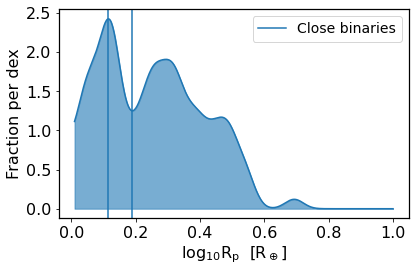

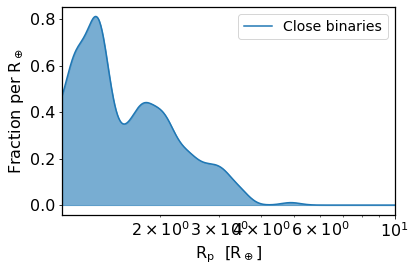

In [19]:

# --------------------------------------------------------------
# 2️⃣  Data selection
# --------------------------------------------------------------
# `good` and `close` are the boolean masks you already have
mask = good & close

# Take the radii column as a NumPy array and drop non‑positive values
# (log10 is undefined for ≤ 0)
radii = db_filtered.loc[mask, 'Rppri'].values
radii = radii[radii > 0]          # safety filter

# --------------------------------------------------------------
# 3️⃣  (Optional) Normalising weights – each planet contributes 1/N
# --------------------------------------------------------------
N = len(radii)
weights = np.full(N, 1.0 / N)     # sum(weights) == 1  → unit‑area normalisation

# --------------------------------------------------------------
# 4️⃣  Work in log10‑space
# --------------------------------------------------------------
log_radii = np.log10(radii)       # variable on which we will fit the KDE

# Build the KDE.  `bw_method` can be a scalar (bandwidth factor) or a
# string such as "scott"/"silverman".  Here we keep the 0.15 you tried.
kde_log = gaussian_kde(log_radii, bw_method=0.15, weights=weights)

# --------------------------------------------------------------
# 5️⃣  Evaluation grid – exactly the same grid you would have used
#     for a log‑spaced histogram
# --------------------------------------------------------------
# `log_bin_edges` should be the *log10* edges you used for the histogram,
# e.g.   log_bin_edges = np.log10(np.logspace(...))  or whatever you built.
log_x_grid = np.linspace(0.01, 1, 500)  # uniform in log10

# NOTE:  Two ways to visualise the result
# --------------------------------------------------------------
# A)  KDE **in log‑space** (direct analogue of a log‑spaced histogram)
# --------------------------------------------------------------------
log_density = kde_log(log_x_grid)                 # pdf of log10(R)

# Plotting in log‑space: x‑axis will be log10(R)
fig_a, ax_a = plt.subplots(figsize=(6, 4))
ax_a.plot(log_x_grid, log_density,
          color="#1f77b4", linewidth=1.5, label="Close binaries")
ax_a.fill_between(log_x_grid, log_density,
                  color="#1f77b4", alpha=0.6)
ax_a.set_xlabel(r"$\log_{10} R_{\rm p}$  [R$_\oplus$]")
ax_a.set_ylabel("Fraction per dex")
ax_a.legend()
plt.axvline(0.19)
plt.axvline(0.115)
plt.tight_layout()
plt.show()

# B)  KDE **back‑transformed to linear radius** (so y‑axis is a true pdf in R)
# -------------------------------------------------------------------------
# Convert the log‑space density to linear space using the Jacobian:
#    f_R(R) = f_log(log10 R) / (R * ln(10))
# First turn the log‑grid back into linear radius values:
x_grid = 10 ** log_x_grid                     # linear radius values

# Now apply the transformation:
ln10 = np.log(10.0)
density_linear = log_density / (x_grid * ln10)

# Plotting in linear space (x‑axis in R, y‑axis = probability density)
fig_b, ax_b = plt.subplots(figsize=(6, 4))
ax_b.plot(x_grid, density_linear,
          color="#1f77b4", linewidth=1.5, label="Close binaries")
ax_b.fill_between(x_grid, density_linear,
                  color="#1f77b4", alpha=0.6)

ax_b.set_xlabel(r"$R_{\rm p}$  [R$_\oplus$]")
ax_b.set_ylabel("Fraction per $R_\oplus$")
ax_b.set_xscale('log')          # optional: keep a log‑scaled *x* axis
ax_b.set_xlim(x_grid[0], x_grid[-1])
ax_b.legend()
plt.tight_layout()
plt.show()

In [9]:
10**0.19

1.5488166189124815

### Multiplicity

In [14]:
with open("filtered_data_thebault.pkl", "rb") as f:
     datatb = pickle.load(f)
        


wide_tb_counts = datatb['db_filtered'][~datatb['close']].groupby('KOI').size().reset_index(name='n_planets')
close_tb_counts = datatb['db_filtered'][datatb['close']].groupby('KOI').size().reset_index(name='n_planets')

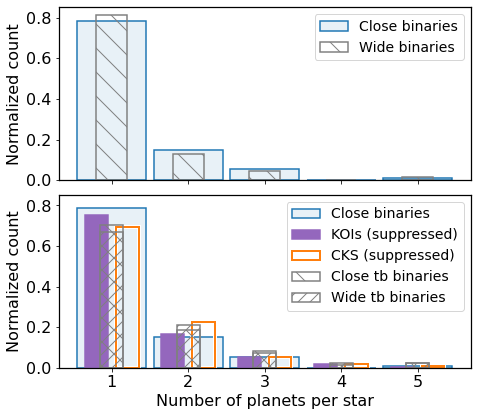

In [20]:
mpl.rcParams['figure.subplot.hspace'] = 0.1

x = np.array([1,2,3,4,5])

wide_planet_counts = db_filtered[~close].groupby('KOI').size().reset_index(name='n_planets')
close_planet_counts = db_filtered[close].groupby('KOI').size().reset_index(name='n_planets')
koi_planet_counts = kois_filtered.groupby('KOI').size().reset_index(name='n_planets')
cks_planet_counts = cks_filtered.groupby('KOI').size().reset_index(name='n_planets')

#close_planet_counts = db_filtered[close & (db_filtered['koi_disposition']=='CONFIRMED')].groupby('KOI').size().reset_index(name='n_planets')
#koi_planet_counts = kois_filtered[kois_filtered['koi_disposition']=='CONFIRMED'].groupby('KOI').size().reset_index(name='n_planets')




fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True, sharey=True) #8.1

## panel for the binaries

nstars = len(close_planet_counts)
ww = 1./np.full(nstars, nstars, dtype=float)
y, _ = np.histogram(close_planet_counts['n_planets'], 
                    weights=ww, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
for ax in axes:
    ax.bar(x, y, edgecolor='#1f77b4', facecolor='#e8f1f7', 
            width=0.9, linewidth=1.5, label='Close binaries')

nstars = len(wide_planet_counts)
ww = 1./np.full(nstars, nstars, dtype=float)
y, _ = np.histogram(wide_planet_counts['n_planets'],  
                    weights=ww, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
axes[0].bar(x, y, edgecolor='gray', facecolor='None', hatch="\\", width=0.4, linewidth=1.5, label='Wide binaries')

''' 
## Theabault table
nstars = len(close_tb_counts)
ww = 1./np.full(nstars, nstars, dtype=float)
y, _ = np.histogram(close_tb_counts['n_planets'],  
                    weights=ww, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
axes[0].bar(x, y, edgecolor='gray', facecolor='None', hatch="\\", width=0.3, linewidth=1.5, label='Wide binaries')

nstars = len(wide_tb_counts)
ww = 1./np.full(nstars, nstars, dtype=float)
y, _ = np.histogram(wide_tb_counts['n_planets'],  
                    weights=ww, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
axes[0].bar(x, y, edgecolor='gray', facecolor='None', hatch="//", width=0.3, linewidth=1.5, label='Wide binaries')
'''

'''
## panel for the raw planet counts

nstars = len(koi_planet_counts)
ww = 1./np.full(nstars, nstars, dtype=float)
y, _ = np.histogram(koi_planet_counts['n_planets'], 
                    weights=ww, bins=[0.5,1.5,2.5,3.5,4.5,5.5])     
axes[1].bar(x-0.2, y, edgecolor='C4', facecolor='None', 
            width=0.3, lw=1.5, label='KOIs (all)')

nstars = len(cks_planet_counts)
ww = 1./np.full(nstars, nstars, dtype=float)
y, _ = np.histogram(cks_planet_counts['n_planets'], 
                    weights=ww, bins=[0.5,1.5,2.5,3.5,4.5,5.5])     
axes[1].bar(x+0.2, y, edgecolor='C1', facecolor='None',  
            width=0.3, lw=1.5, label='CKS (all)')
'''


## panel for suppressed planet counts

y = np.percentile(koi_sim_npl, q=50, axis=0)
axes[1].bar(x-0.2, y, edgecolor='C4', facecolor='C4',  
            width=0.3, lw=1.5, label='KOIs (suppressed)')

y = np.percentile(cks_sim_npl, q=50, axis=0)
axes[1].bar(x+0.2, y, edgecolor='white', facecolor='None',  
            width=0.3, lw=4)
axes[1].bar(x+0.2, y, edgecolor='C1', facecolor='None',  
            width=0.3, lw=2, label='CKS (suppressed)')

nstars = len(close_tb_counts)
ww = 1./np.full(nstars, nstars, dtype=float)
y, _ = np.histogram(close_tb_counts['n_planets'],  
                    weights=ww, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
axes[1].bar(x, y, edgecolor='gray', facecolor='None', hatch="\\", width=0.3, linewidth=1.5, label='Close tb binaries')

nstars = len(wide_tb_counts)
ww = 1./np.full(nstars, nstars, dtype=float)
y, _ = np.histogram(wide_tb_counts['n_planets'],  
                    weights=ww, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
axes[1].bar(x, y, edgecolor='gray', facecolor='None', hatch="//", width=0.3, linewidth=1.5, label='Wide tb binaries')


for ax in axes:
    ax.set_ylabel('Normalized count')
    ax.legend()


plt.xlabel('Number of planets per star')
plt.tight_layout(h_pad=0.4)
if do_multiplicity:
    plt.savefig('multiplicity.png')